## 初期設定

In [1]:
from datetime import datetime
from time import sleep
import requests
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from mpl_finance import candlestick2_ohlc, volume_overlay
%matplotlib inline

In [2]:
# UNIX時間から文字列に変換
def t2s(the_time):
    return datetime.fromtimestamp(int(the_time)).strftime('%Y/%m/%d %H:%M')

## 5分足の取得

In [3]:
import mysql.connector

cnt = mysql.connector.connect(
    host='localhost',
    port='3306',
    db='bitmex',
    user='bitmex',
    password='bitmex',
    charset='utf8'
)

cur = cnt.cursor()

In [4]:
sql = "select t, o, h, l, c, v from xbtusd_5m order by t asc"
cur.execute(sql)
data = cur.fetchall()

## Pandas に変換

In [5]:
df = pd.DataFrame(data)
df.columns = ["Time", "Open", "High", "Low", "Close", "Volume"]

In [6]:
print(df.index)
df[0:10]

RangeIndex(start=0, stop=213560, step=1)


,Time,Open,High,Low,Close,Volume
0,1483228800,968.3,968.8,966.7,967.0,119555
1,1483229100,967.0,967.0,966.9,966.9,26962
2,1483229400,966.9,966.9,964.9,964.9,124137
3,1483229700,964.9,965.0,964.8,964.8,3001
4,1483230000,964.8,964.8,964.8,964.8,0
5,1483230300,964.8,965.1,964.5,964.9,48000
6,1483230600,964.9,965.0,964.9,965.0,2501
7,1483230900,965.0,967.8,965.6,967.8,130501
8,1483231200,967.8,967.8,967.1,967.1,50
9,1483231500,967.1,967.4,967.4,967.4,100


## 分析

In [7]:
time_frame = 180 # 考慮するのは2時間
bar_type   = 5   # 5分足
frame_size = int(time_frame / bar_type)  # データ数

In [8]:
bars_prev_base_price = 1    # 判断基準となる価格を算出する足の数
bars_ahead_prediction = 12  # 価格を予測するバーが現在からどの程度離れているか
deviation_criteria = 5  # 価格の変動優位性を考慮する基準 (%)
bars_risk_rewards_calc = 12 # リスクリワードを計算する時に用いる過去バーの数

### 一定時間内の値動きと将来価格の関係性について集計

In [9]:
%%time
run_times = 10000
results = []
for i in range(run_times):
    idx = random.randint(0,len(df)-frame_size-bars_ahead_prediction)
    idx2 = idx + frame_size
    idx3 = idx2 + bars_ahead_prediction
    ds = df[idx:idx2]
    ds2 = df[idx:idx3]
    
    base_price = np.mean( df[idx2-bars_prev_base_price:idx2]["Close"].values )  # 変化前価格
    future_price = df[idx3-1:idx3]["Open"].values[0]  # 将来価格 
    diff = future_price - base_price
    deviation = diff / base_price * 100.0  # 変化率 (%)
    
    # リスクリワードの計算
    rds = df[idx2-bars_risk_rewards_calc:idx2]
    highs = rds['High'].values
    lows = rds['Low'].values
    highest = max(highs)
    lowest = min(lows)
    if deviation > 0:
        risk = base_price - lowest
        reward = future_price - base_price
    else:
        risk = highest - base_price
        reward = base_price - future_price

    rs_ratio = reward / risk if risk > 0.0 else 0.0

    results.append( (deviation, abs(deviation), diff, rs_ratio, base_price, future_price, idx, idx2, idx3) )

CPU times: user 5.48 s, sys: 20.9 ms, total: 5.5 s
Wall time: 5.54 s


In [10]:
ret = pd.DataFrame(results)
ret.columns = ["Dev", "DevA", "Diff", "RRR", "Base", "Future", "idx", "idx2", "idx3"]

ここで各カラムの意味は次の通り
 - Dev: 将来価格が現在に比べてどの程度変化したか (%)
 - DevA: Dev の絶対値
 - Diff: 将来価格の現在価格からの変化 (USD)
 - RRR: Risk Reward Ratio
 - Baes: 現在価格
 - Future: 将来価格
 - idx: 過去データの開始インデックス
 - idx2: 将来価格データの開始インデックス
 - idx3: 将来価格算出のためのインデックス (idx3-1のデータを使用）

In [11]:
ret[0:10]

,Dev,DevA,Diff,RRR,Base,Future,idx,idx2,idx3
0,0.111759,0.111759,7.0,4.666667,6263.5,6270.5,192190,192226,192238
1,0.119454,0.119454,21.0,0.079696,17580.0,17601.0,98184,98220,98232
2,-0.404040,0.404040,-7.0,1.707317,1732.5,1725.5,37102,37138,37150
3,-0.716237,0.716237,-59.0,2.809524,8237.5,8178.5,93752,93788,93800
4,-0.421613,0.421613,-3.8,0.716981,901.3,897.5,2435,2471,2483
5,3.117529,3.117529,65.2,1.009288,2091.4,2156.6,42200,42236,42248
6,0.136178,0.136178,10.5,1.750000,7710.5,7721.0,149241,149277,149289
7,-0.039825,0.039825,-2.5,0.090909,6277.5,6275.0,177897,177933,177945
8,0.171992,0.171992,1.9,0.463415,1104.7,1106.6,14802,14838,14850
9,-1.699799,1.699799,-46.6,3.477612,2741.5,2694.9,47123,47159,47171


### 将来価格の変化量と発生回数

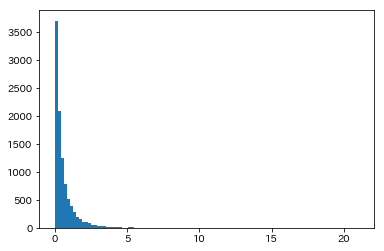

In [12]:
devs = ret["DevA"]
hist_fig = plt.hist(devs, bins=100)

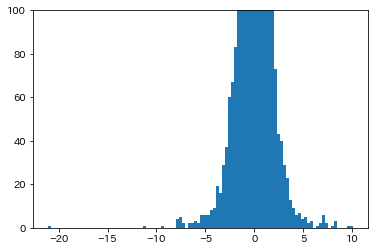

In [13]:
devs = ret["Dev"]
plt.ylim(0,100)
hist_fig = plt.hist(devs, bins=100)

In [14]:
freqs = []
details = []
dev_targets = list(np.arange(0.5, 5.0, 0.25))
for dev in dev_targets:
    occured = len(ret[ret["DevA"]>dev])
    rate = occured / run_times * 100
    details.append( [dev, occured, rate] )
    freqs.append(rate)

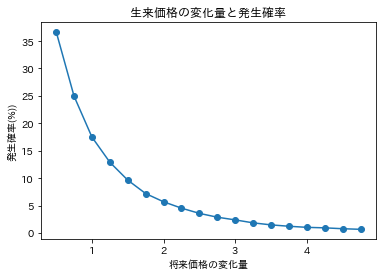

In [15]:
plt.title("生来価格の変化量と発生確率")
plt.xlabel("将来価格の変化量")
plt.ylabel("発生確率(%))")
rate_fig = plt.plot(dev_targets, freqs, marker="o")

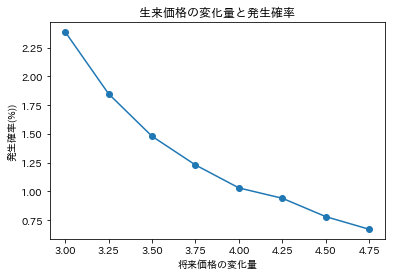

In [16]:
plt.title("生来価格の変化量と発生確率")
plt.xlabel("将来価格の変化量")
plt.ylabel("発生確率(%))")
rate_fig2 = plt.plot(dev_targets[10:], freqs[10:], marker="o")

In [18]:
alpha = ret[ ret["DevA"]>3.5]
alpha2 = alpha[ alpha["RRR"] > 2]
alpha2

,Dev,DevA,Diff,RRR,Base,Future,idx,idx2,idx3
145,-9.515701,9.515701,-1397.0,3.415648,14681.0,13284.0,102233,102269,102281
182,7.982404,7.982404,744.0,6.672646,9320.5,10064.5,109879,109915,109927
207,5.635071,5.635071,594.5,3.738994,10550.0,11144.5,109669,109705,109717
373,-3.650065,3.650065,-93.0,8.378378,2547.9,2454.9,47451,47487,47499
436,5.165298,5.165298,607.0,17.098592,11751.5,12358.5,110605,110641,110653
456,4.349796,4.349796,192.0,3.368421,4414.0,4606.0,198280,198316,198328
549,4.576811,4.576811,172.5,9.324324,3769.0,3941.5,202212,202248,202260
665,-4.149558,4.149558,-105.1,6.110465,2532.8,2427.7,41664,41700,41712
754,-4.256297,4.256297,-101.9,3.116208,2394.1,2292.2,47607,47643,47655
756,-3.665947,3.665947,-271.5,4.601695,7406.0,7134.5,115639,115675,115687


In [20]:
def make_plot(ds, mode="base", label=True, filename=None):
    # ローソク足をプロット
    wsize = frame_size if mode=="base" else frame_size + bars_ahead_prediction
    fig = plt.figure(figsize=(wsize/6, 4))
    ax = plt.subplot(1, 1, 1)

    candlestick2_ohlc(ax, ds["Open"], ds["High"], ds["Low"], ds["Close"], width=0.9, colorup="#0000ff", colordown="#ff0000", alpha=1.0)
    #ax.set_xticklabels([(df.index[int(x)].strftime("%Y/%M/%D") if x < df.shape[0] else x) for x in ax.get_xticks()], rotation=90)
    ax.set_xlim([0, ds.shape[0]]) # 横軸の範囲はデータの個数(df.shape[0]個)までに変更しておく
    #ax.set_ylabel("Price")

    # ローソク足を上側 1/2 に収める
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom - (top - bottom) , top)


    # 出来高のチャートをプロット
    ax2 = ax.twinx()
    volume_overlay(ax2, ds["Open"], ds["Close"], ds["Volume"], width=1, colorup="#00ff00", colordown="#00ff00", alpha=1.0)
    ax2.set_xlim([0, ds.shape[0]])

    # 出来高チャートは下側 1/3 に収める
    ax2.set_ylim([0, ds["Volume"].max() * 3])
    #ax2.set_ylabel("Volume")
    
    if not label:
        ax.tick_params(labelbottom=False, labelleft=False, labelright=False, labeltop=False)
        ax.tick_params(bottom=False, left=False, right=False, top=False)
        ax2.tick_params(labelbottom=False, labelleft=False, labelright=False, labeltop=False)
        ax2.tick_params(bottom=False, left=False, right=False, top=False)
    
    if filename:
        fig.savefig(filename)
        plt.close(fig)

In [21]:
def plot_comp(ret):
    idx = ret["idx"].values[0]
    idx2 = ret["idx2"].values[0]
    idx3 = ret["idx3"].values[0]
    ds = df[idx:idx2]
    ds2 = df[idx:idx3]
    make_plot(ds, mode="base")
    make_plot(ds2, mode="prediction")

### 変化率の基準値の設定

In [22]:
dev_criterion = 3.5

In [23]:
%%time
for i in range(1,len(ret)):
    the_ret = ret[i-1:i]
    the_dev = the_ret["Dev"].values[0]
    the_rrr = the_ret["RRR"].values[0]

    dir = "nochange"
    counts = {"nochange":0, "up":0, "down":0}

    if the_rrr > 2.0:
        if the_dev > dev_criterion:
            dir = "up"
        if the_dev < - dev_criterion:
            dir = "down"

    counts[dir] += 1
    
    filename1 = dir + "/" + str(the_ret['idx'].values[0]) + "_1.png"
    filename2 = dir + "/" + str(the_ret['idx'].values[0]) + "_2.png"

    idx = the_ret["idx"].values[0]
    idx2 = the_ret["idx2"].values[0]
    idx3 = the_ret["idx3"].values[0]
    ds = df[idx:idx2]
    ds2 = df[idx:idx3]
    make_plot(ds, mode="base", filename=filename1)
    make_plot(ds2, mode="prediction", filename=filename2)

counts

/Users/tatsumi/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/matplotlib/axes/_base.py:3239: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=0, top=0
  'bottom=%s, top=%s') % (bottom, top))


CPU times: user 1h 6min 51s, sys: 32min 32s, total: 1h 39min 23s
Wall time: 5h 26min 18s
